In [1]:
import numpy as np
import os

from matplotlib import pyplot as plt 

from steves_utils.stratified_dataset.traditional_accessor import Traditional_Accessor_Factory

from steves_utils.utils_v2 import get_datasets_base_path

from steves_utils.transforms import get_chained_transform

In [2]:
from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

taf_source = Traditional_Accessor_Factory(
    labels=ALL_SERIAL_NUMBERS,
    domains=ALL_DISTANCES_FEET_NARROWED,
    num_examples_per_domain_per_label=100,
    pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
    seed=1337,
    x_transform_func=get_chained_transform(["jitter_256_10", "take_200", "resample_20Msps_to_25Msps"])
#     x_transform_func=get_chained_transform(["take_200"])
)
train_original_source, val_original_source, test_original_source = \
    taf_source.get_train(), taf_source.get_val(), taf_source.get_test()

oracle_x, _, _ = next(iter(train_original_source))

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

taf_source = Traditional_Accessor_Factory(
    labels=ALL_NODES,
    domains=[1],
    num_examples_per_domain_per_label=100,
    pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
    seed=1337,
    x_transform_func=get_chained_transform(["jitter_256_10", "lowpass_+/-10MHz", "take_200"])
)
train_original_source, val_original_source, test_original_source = \
    taf_source.get_train(), taf_source.get_val(), taf_source.get_test()

cores_x, _, _ = next(iter(train_original_source))

ORACLE is sampled at 5Msps, the rest are at 25Msps

In [4]:
print(oracle_x.shape)
print(cores_x.shape)

torch.Size([2, 256])
torch.Size([2, 256])


In [5]:
# Stolen from https://stackoverflow.com/questions/2598734/numpy-creating-a-complex-array-from-2-real-ones
# oracle_x = np.apply_along_axis(lambda args: [complex(*args)], 1, oracle_x.T).flatten()
oracle_x = oracle_x[0] + oracle_x[1]*1j

cores_x = np.apply_along_axis(lambda args: [complex(*args)], 1, cores_x.T).flatten()

# oracle_x = oracle_x[:160]
# cores_x  = cores_x[:200]

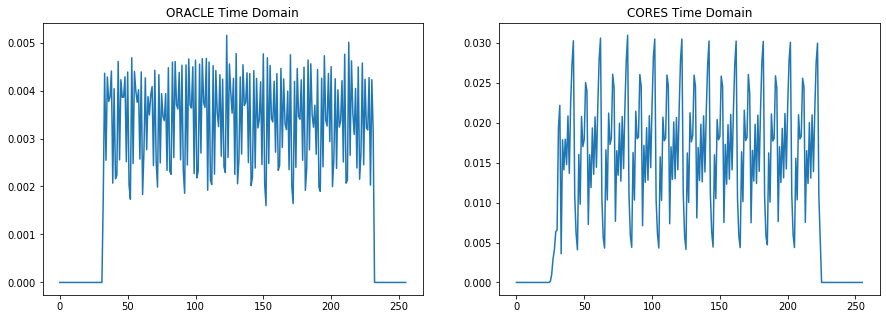

In [6]:
plt.figure(figsize=(15,5))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.set_title("ORACLE Time Domain")
ax2.set_title("CORES Time Domain")

ax1.plot(range(len(oracle_x)),np.abs(oracle_x))
ax2.plot(range(len(cores_x)),np.abs(cores_x))

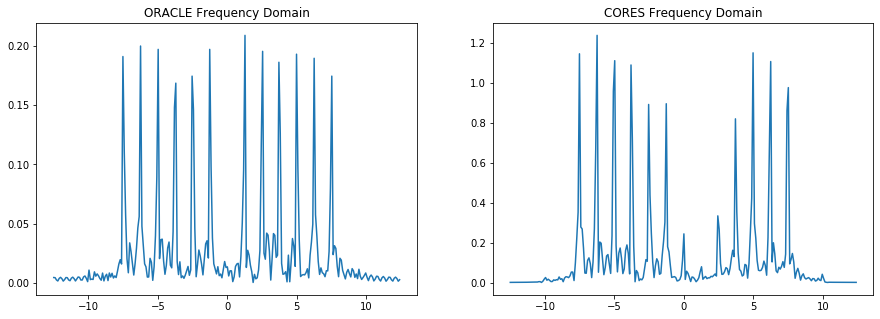

In [7]:
plt.figure(figsize=(15,5))
# ORACLE
f = 25e6
signal_spectrum = np.fft.fftshift(np.fft.fft(oracle_x))
freqs = np.fft.fftshift(np.fft.fftfreq(len(oracle_x), d=1.0/f))
ax1 = plt.subplot(1,2,1)
ax1.set_title("ORACLE Frequency Domain")
ax1.plot(freqs / 1e6, np.abs(signal_spectrum))  # in MHz

# CORES
f = 25e6
signal_spectrum = np.fft.fftshift(np.fft.fft(cores_x))
freqs = np.fft.fftshift(np.fft.fftfreq(len(cores_x), d=1.0/f))
ax2 = plt.subplot(1,2,2)
ax2.set_title("CORES Frequency Domain")
ax2.plot(freqs / 1e6, np.abs(signal_spectrum))  # in MHz


# ax2 = plt.subplot(1,2,2)
# ax2.set_title("CORES Time Domain")

# ax2.plot(range(len(cores_x)),np.abs(cores_x))

In [8]:
# Upsample and clip oracle
from scipy import signal

original_sample_rate = 20e6
target_sample_rate = 25e6

oracle_x_prime = signal.resample(oracle_x, int(len(oracle_x)*target_sample_rate/original_sample_rate))
oracle_x_prime = oracle_x_prime[:200]

In [9]:
# Taken from https://stackoverflow.com/questions/25191620/creating-lowpass-filter-in-scipy-understanding-methods-and-units
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt



def build_butter_filter(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def apply_filter(b,a,x):
    y = lfilter(b, a, x)
    return y

# Filter requirements.
order = 15
fs = 25e6       # sample rate, Hz
cutoff = 10e6  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = build_butter_filter(cutoff, fs, order)


cores_x_prime = apply_filter(b, a, cores_x)
# cores_x_prime = cores_x

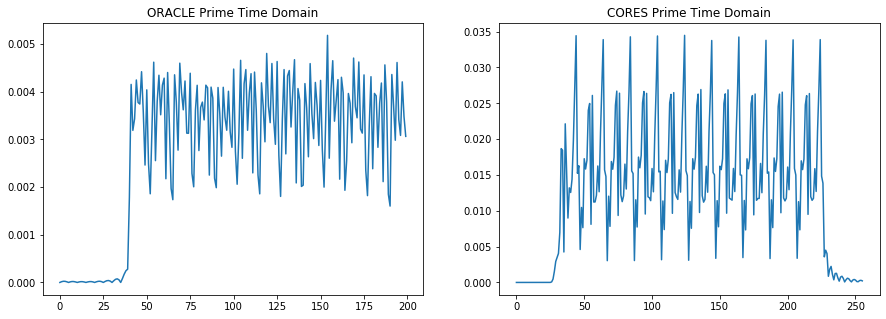

In [10]:
plt.figure(figsize=(15,5))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.set_title("ORACLE Prime Time Domain")
ax2.set_title("CORES Prime Time Domain")

ax1.plot(range(len(oracle_x_prime)),np.abs(oracle_x_prime))
ax2.plot(range(len(cores_x_prime)),np.abs(cores_x_prime))

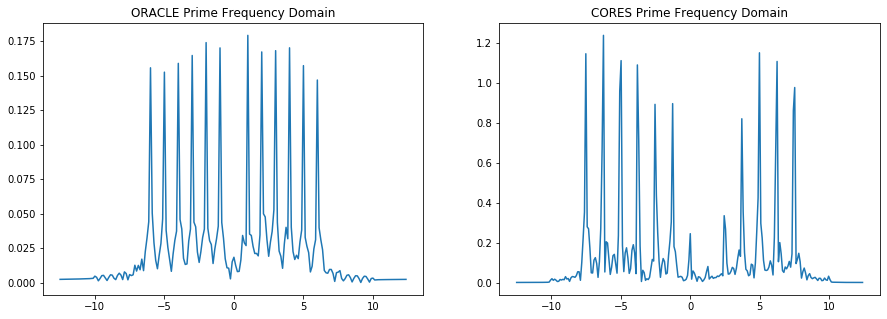

In [11]:
plt.figure(figsize=(15,5))
# ORACLE
f = 25e6
signal_spectrum = np.fft.fftshift(np.fft.fft(oracle_x_prime))
freqs = np.fft.fftshift(np.fft.fftfreq(len(oracle_x_prime), d=1.0/f))
ax1 = plt.subplot(1,2,1)
ax1.set_title("ORACLE Prime Frequency Domain")
ax1.plot(freqs / 1e6, np.abs(signal_spectrum))  # in MHz

# CORES
f = 25e6
signal_spectrum = np.fft.fftshift(np.fft.fft(cores_x_prime))
freqs = np.fft.fftshift(np.fft.fftfreq(len(cores_x_prime), d=1.0/f))
ax2 = plt.subplot(1,2,2)
ax2.set_title("CORES Prime Frequency Domain")
ax2.plot(freqs / 1e6, np.abs(signal_spectrum))  # in MHz